In [1]:
#first let us import the necessary modules

import matplotlib.pyplot as plt
from preprocessing import *
from ispy_utils import *
import numpy as np
import pydicom

In [2]:
#setting file paths

#precontrast image path
file_pre ='data/manifest-1735062601251/ISPY2/ISPY2-119928/08-07-2003-119928T0-ISPY2MRIT0-52196/6.000000-ISPY2 DynaVIEWS 90s Pre-50693'

#postcontrast image path
file_post = 'data/manifest-1735062601251/ISPY2/ISPY2-119928/08-07-2003-119928T0-ISPY2MRIT0-52196/8.000000-ISPY2 DynaVIEWS 90s Post-87526'

def extract_pixel_spacing(file_path):
    # Extracting pixel spacing (x, y dimensions)
    dicom_metadata = pydicom.dcmread(file_path)
    pixel_spacing = dicom_metadata.PixelSpacing  # This is usually a list: [row_spacing, column_spacing]
    slice_thickness = getattr(dicom_metadata, 'SliceThickness', None)  # It's optional in some cases
    print(f"Pixel Spacing: {pixel_spacing}")
    print(f"Slice Thickness: {slice_thickness} mm")
    return pixel_spacing

pixel_spacing = extract_pixel_spacing(file_post + "/1-032.dcm")
slice_thickness = 1.1

Pixel Spacing: [0.8072916865, 0.8072916865]
Slice Thickness: 1.1000000238 mm


(384, 384, 176)


(-0.5, 383.5, 383.5, -0.5)

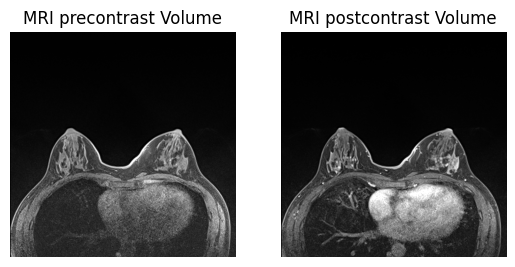

In [8]:
#apply function from ispymri.py 
image_array_pre, dcm_data_pre = read_ispy_mri(file_pre)
image_array_pre = zscore_image(normalize_image(image_array_pre))
# saving image - will be used as an input to prediction code
np.save('./input_pre_119928/output.npy', image_array_pre)
print(image_array_pre.shape)  #optional

image_array_post, dcm_data_post = read_ispy_mri(file_post)
image_array_post = zscore_image(normalize_image(image_array_post))
np.save('./input_post_119928/output.npy', image_array_post)


#plotting both the images

plt.subplot(1,2,1)
plt.title('MRI precontrast Volume')
plt.imshow(image_array_pre[:,:,119], cmap = 'gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title('MRI postcontrast Volume')
plt.imshow(image_array_post[:,:,119], cmap='gray')
plt.axis('off')

(384, 384, 176)


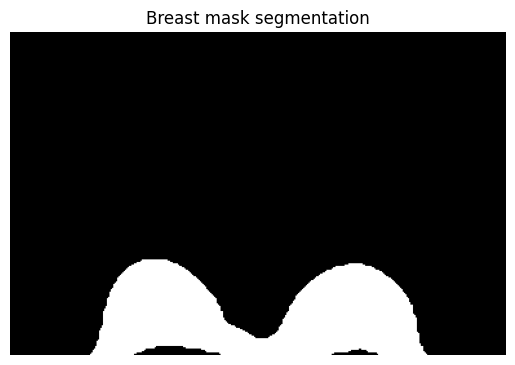

In [22]:
breast_mask_seg = np.load('./mask_119928/output.npy')
print(breast_mask_seg.shape)

#plotting the mask
plt.imshow(breast_mask_seg[0:250, :, 90] > 0.5, cmap = 'gray')
plt.title('Breast mask segmentation')
plt.axis('off')
plt.show()

In [23]:
#Function to calculate breast volume
def calculate_breast_volume(npy_file, pixel_spacing, slice_thickness):

    dicom_data = np.load(npy_file)

    breast_voxels = np.sum(dicom_data[2,0:350, :,:] > 0.5)
    print(f"Total Voxels: {breast_voxels} ")

    voxel_volume_mm3 = pixel_spacing[0] * pixel_spacing[1] * slice_thickness

    total_volume_mm3 = breast_voxels * voxel_volume_mm3

    volume_ml = total_volume_mm3 / 1000
    
    return volume_ml

def calculate_mask_volume(npy_file, pixel_spacing, slice_thickness):

    dicom_data = np.load(npy_file)

    breast_voxels = np.sum(dicom_data[0:250, :, :] > 0.5)
    print(f"Total Voxels: {breast_voxels} ")

    voxel_volume_mm3 = pixel_spacing[0] * pixel_spacing[1] * slice_thickness
   
    total_volume_mm3 = breast_voxels * voxel_volume_mm3

    volume_ml = total_volume_mm3 / 1000
    
    return volume_ml

def plot_dicom(dicom_data, slice_index=None, cmap='gray', title='DICOM Image'):
    dicom_data_plot = np.load(dicom_data)
    print(dicom_data_plot.shape)
    plt.imshow(dicom_data_plot[2, :, :, slice_index] > 0.5, cmap = 'gray')
    plt.axis('off')
    plt.show()

In [24]:
breast_mask_path = './mask_119928/output.npy'


breast_volume = calculate_mask_volume(breast_mask_path, pixel_spacing, slice_thickness)
print(f"Breast Volume: {breast_volume:.2f} mL")

Total Voxels: 1335874 
Breast Volume: 957.68 mL


python predict.py --target-tissue dv --image ./input_pre_119928 --input-mask ./mask_119928 --save-masks-dir ./fgt_pre_119928 --model-save-path ./trained_models/dv_model.pth

In [19]:
#saving pre and post contrast into 3D
import numpy as np
fgt_seg_42 = np.load('fgt_pre_119928/output.npy')
fgt_seg_42_post = np.load('fgt_post_119928/output.npy')

slice_42_pre_3d = fgt_seg_42[2,:,:,:]
np.save('fgt_pre_119928/42_3d_pre.npy', slice_42_pre_3d)

print(slice_42_pre_3d.shape)

slice_42_post_3d = fgt_seg_42_post[2,:,:,:]
np.save('fgt_post_119928/42_3d_post.npy', slice_42_post_3d)

(384, 384, 176)


In [9]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np

pre_contrast = np.load('./fgt_pre_119928/42_3d_pre.npy')
post_contrast = np.load('./fgt_post_119928/42_3d_post.npy')

mask = np.load('./mask_119928/output.npy')

voxel_dimensions = (0.8072916865, 0.8072916865, 1.1)  
voxel_volume = np.prod(voxel_dimensions)  

percent_enhancement = (post_contrast - pre_contrast) / pre_contrast * 100
percent_enhancement = percent_enhancement * (pre_contrast != 0)
percent_enhancement = percent_enhancement * (mask>0.5)


n_fgt_voxel = np.sum(percent_enhancement > 90)  #change based on desired threshold
print(f'{n_fgt_voxel} total voxels')

print(f'{n_fgt_voxel * voxel_volume} cubic mm')
fgt_ccs = (n_fgt_voxel * voxel_volume)/1000
print(f'{fgt_ccs} cubic cm')

727134 total voxels
521276.4412218933 cubic mm
521.2764412218933 cubic cm
